# Проверка различных гипотез

In [34]:
import numpy as np
from scipy import stats
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
placebo = np.array([57, 27, 32, 31, 34, 38, 71, 33, 34, 53, 36, 42, 26, 52, 36, 55, 36,
       42, 36, 54, 34, 29, 33, 33], dtype=int64)
treatment = np.array([62, 49, 30, 34, 38, 36, 77, 51, 45, 42, 43, 57, 36, 58, 35, 60, 33,
       49, 33, 59, 35, 37, 45, 29], dtype=int64)

## Проверка гипотезы о справедливости предполагаемого распределения

Статистика критерия хи-квадрат: $$\chi^2=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{np_i}$$
При справедливости нулевой гипотезы имеет распределение хи-квадрат с числом степеней свободы $K-1-m$, где $m$ - число параметров распределения, оцененных по выборке.

In [15]:
# из условий задачи
mean = 1.937
# для разбиения по корзинам можно использовать np.bincount()
observed_frequences = np.array([379, 262, 684, 353, 128,  35,  16,   8,  10,   1,   1,   1], dtype=int64) # частоты полученные из эксперимента
# Предположим, что данные имеют распределение Пуассона, тогда:
expected_frequences = [sum(observed_frequences)*stats.poisson.pmf(x, mean) for x in range(len(observed_frequences))]
stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=357721.69128180924, pvalue=0.0)

Получается, что нулевая гипотеза не верна

#### Проверка гипотезы о нормальности распределения QQ-plot

Точки должны лежать на диагонали. Если нет, то не факт, что нормальное.

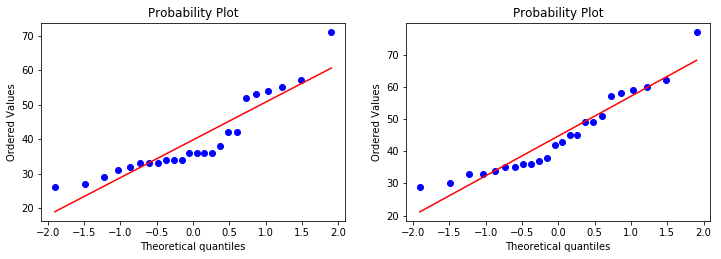

In [20]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(placebo, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(treatment, dist="norm", plot=pylab)
pylab.show()

#### Проверка гипотезы о нормальности распределения (Критерий Шапиро-Уилка)

In [22]:
# опровергает нормальность
stats.shapiro(placebo)

(0.8574873208999634, 0.00302018690854311)

## Параметрические критерии

### Биномиальное распределение

Проверяем, что вероятность правильного ответа $p$ при условии, что получено $k$ верных ответов из $n$ вопросов

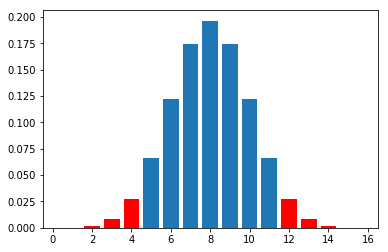

In [7]:
#Пусть n = 16, k = 12
n = 16
k = 12
p = 0.5
x = np.linspace(0,16,17)
F_H0 = stats.binom(n, p) # Биномиальное распределение

pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(k, n, n - k + 1), F_H0.pmf(np.linspace(k, n, n - k + 1)), align = 'center', color='red')
pylab.bar(np.linspace(0, n - k, n - k + 1), F_H0.pmf(np.linspace(0, n - k, n - k + 1)), align = 'center', color='red')
xlim(-0.5, n + 0.5) 
pylab.show()

При двусторонней альтернативе суммируем красные столбцы, при 'greater' -- правые

При значении статистики меньше 0.05 получаем, что вероятность не равна $p$

In [8]:
stats.binom_test(k, n, p, alternative = 'two-sided')

0.076812744140625

### Разница долей

In [35]:
np.random.seed(1)
statistical_population = np.random.randint(2, size = 100000) #генеральная совокупность
random_sample_1 = np.random.choice(statistical_population, size = 1000) # первая выборка из совокупности
random_sample_2 = np.random.choice(statistical_population, size = 1000) # первая выборка из совокупности
def make_conf_matrix_ind(sample1, sample2):
    output = pd.DataFrame([[sample1.sum(), len(sample1 - sample1.sum())], 
                           [sample2.sum(), len(sample2 - sample2.sum())]])
    output.columns = ['pos', 'neg']
    output['sum'] = output['pos'] + output['neg']
    return output

def make_conf_matrix_rel(sample1, sample2):
    if len(sample1) != len(sample2):
        raise ValueError('it is not relative samples')
    output = {
        'e': np.logical_and(sample1 > 0.5, sample2 > 0.5).sum(),
        'f': np.logical_and(sample1 > 0.5, sample2 < 0.5).sum(),
        'g': np.logical_and(sample1 < 0.5, sample2 > 0.5).sum(),
        'h': np.logical_and(sample1 < 0.5, sample2 < 0.5).sum(),
        'n': float(len(sample1)),
    }
    
    return output

matrix_ind = make_conf_matrix_ind(random_sample_1, random_sample_2)
matrix_rel = make_conf_matrix_rel(random_sample_1, random_sample_2)

Независимые выборки

In [43]:
# Независимые выборки
def proportions_diff_z_stat_ind(matrix):
    n1 = matrix.iloc[0]['sum']
    n2 = matrix.iloc[1]['sum']
    
    p1 = matrix.iloc[0]['pos'] / n1
    p2 = matrix.iloc[1]['pos'] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
# Связанные выборки
def proportions_diff_z_stat_rel(matrix):
    n = matrix['n']
    
    f = matrix['f']
    g = matrix['g']
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)
    
print("independent p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(matrix_ind)))
print("relative p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(matrix_rel)))

independent p-value: 0.815639
relative p-value: 0.680885


### Критерий Стьюдента (только для параметров, имеющих нормальное распределение)


In [30]:
import statsmodels.stats.weightstats

#### Одновыборочный критерий

In [18]:
# проверим о том, что среднее значение способности к самолечению равно 50.
possible_mean = 50.
stats.ttest_1samp(placebo, possible_mean)

Ttest_1sampResult(statistic=-4.438003341905128, pvalue=0.00018894293251080175)

#### Двухвыборочный независимые выборки

In [26]:
#критерий для независимых выборок
#equal_var = False -- так как нет информации о равенстве дисперсий
stats.ttest_ind(placebo, treatment, equal_var = False)

Ttest_indResult(statistic=-1.4521635018159091, pvalue=0.1532919977404709)

In [31]:
#интервальная оценка разности средних по двум выборкам
cm = statsmodels.stats.weightstats.CompareMeans(statsmodels.stats.weightstats.DescrStatsW(treatment), 
                                                statsmodels.stats.weightstats.DescrStatsW(placebo))
print("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

95% confidence interval: [-1.915927, 11.832593]


#### Двухвыборочный связанные выборки

In [32]:
# здесь стоит проверять на нормальность попарные разности выборок!
stats.ttest_rel(treatment, placebo)

Ttest_relResult(statistic=3.2223624451230406, pvalue=0.003771488176381471)

## Непараметрические критерии

  |Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки) |
  |------------- | -------------|----|----|
  |**Знаков**  | $\times$ | | $\times$ |
  |**Ранговый** | $\times$  | $\times$ | $\times$  |
  |**Перестановочный** | $\times$  | $\times$ | $\times$ |

In [44]:
data = np.array([0.3484705, 0.6406202, 0.5498178, 0.5374537, 0.4004438, 0.4262919,
       0.4171558, 0.4779768, 0.4506574, 0.4766018, 0.4886766, 0.4847412,
       0.4816139, 0.4894059, 0.4673653, 0.4673297])

### Одновыборочные

In [54]:
import statsmodels.stats.descriptivestats
import itertools

#### Критерий знаков -- оценивает медиану (ни один объект не должен равняться медиане!)

Универсальный, но неточный отбойник. Подходит для выборок, где несколько параметров имеют лишь верхнюю или ниждюю оценку (цензурированные выборки)

In [47]:
possible_median = 0.5
stat, p_val = statsmodels.stats.descriptivestats.sign_test(data, possible_median)
print(p_val)

0.021270751953125


#### Критерий знаковых рангов Вилкоксона -- оценивает медиану (ни один объект не должен равняться медиане!)

Точнее критерия знаков, но требует, чтобы распределение было симметричным относительно медианы

In [50]:
stats.wilcoxon(data - possible_median)

WilcoxonResult(statistic=35.0, pvalue=0.08793560714236243)

#### Перестановочный критерий -- оценивает среднее

Требуется симметричность распределения относительно среднего

In [70]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    # сначала вычитаем среднее
    centered_sample = list(map(lambda x: x - mean, sample))
    # затем ищем ве возможные перестановки знаков
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

def permutation_test_1sample(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

possible_mean = 0.5
print("p-value: %f" % permutation_test_1sample(data, possible_mean))

p-value: 0.157776


### Двухвыборочные несвязанные

In [57]:
data_1 = data - 0.01
data_2 = data + 0.2

#### Ранговый критерий Манна-Уитни

Здесь, похоже, следует помнить, что альтернатива 'greater' соответствует случаю, когда среднее первого распределения > второго

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [59]:
stats.mannwhitneyu(data_1, data_2)

MannwhitneyuResult(statistic=4.0, pvalue=1.6231979802711256e-06)

#### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [68]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

# расчёт нулевого распределения. Мы можем получить значение в 1-й и 2-й выборке с равными вероятностями
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test_ind(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print("p-value: %f" % permutation_test_ind(data_1, data_2, max_permutations = 10000))

p-value: 0.000100


### Двухвыборочные связанные

#### Критерий знаков

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [62]:
stat, p_val = statsmodels.stats.descriptivestats.sign_test(data_2 - data_1)
print(p_val)

3.0517578125e-05


#### Критерий знаковых рангов Уилкоксона

$H_0\colon med\left(X_1-X_2\right)=0,$

$H_1\colon med\left(X_1-X_2\right)\neq0$

In [63]:
stats.wilcoxon(data_2, data_1) #или stats.wilcoxon(data_2 - data_1)

WilcoxonResult(statistic=0.0, pvalue=0.00036928682980612174)

#### Перестановочный критерий

$H_0\colon \mathbb{E}(X_1 - X_2) = 0$

$H_1\colon \mathbb{E}(X_1 - X_2) \neq 0$

In [71]:
print("p-value: %f" % permutation_test_1sample(data_2 - data_1, 0., 
                               max_permutations = 1000))

p-value: 0.000000
